# Imports

In [1]:
import numpy as np
from matplotlib import pyplot as plt
import imageio
import glob
from time import time

# Load data

In [2]:
def load_mnist():
    # Loads the MNIST dataset from png images
 
    NUM_LABELS = 10        
    # create list of image objects
    test_images = []
    test_labels = []    
    
    for label in range(NUM_LABELS):
        for image_path in glob.glob("MNIST/Test/" + str(label) + "/*.png"):
            image = imageio.imread(image_path)
            test_images.append(image)
            letter = [0 for _ in range(0,NUM_LABELS)]    
            letter[label] = 1
            test_labels.append(letter)  
            
    # create list of image objects
    train_images = []
    train_labels = []    
    
    for label in range(NUM_LABELS):
        for image_path in glob.glob("MNIST/Train/" + str(label) + "/*.png"):
            image = imageio.imread(image_path)
            train_images.append(image)
            letter = [0 for _ in range(0,NUM_LABELS)]    
            letter[label] = 1
            train_labels.append(letter)                  
            
    X_train= np.array(train_images).reshape(-1,784)/255.0
    Y_train= np.array(train_labels)
    X_test= np.array(test_images).reshape(-1,784)/255.0
    Y_test= np.array(test_labels)
    
    return X_train.T, Y_train.T, X_test.T, Y_test.T

In [3]:
def plot_digits(X,Y,nr):
    fig, axes = plt.subplots(1, nr, figsize=(12,4))
    
    # Shuffle the data and labels in the same order
    shuffle_indices = np.arange(X.shape[1])
    np.random.shuffle(shuffle_indices)

    X = X[:, shuffle_indices]
    Y = Y[:, shuffle_indices]
    
    # Plots
    for i, ax in enumerate(axes):
        img = X[:,i].reshape(28, 28)
        label = np.argmax(Y[:,i])
        ax.imshow(img, cmap="gray")
        ax.set_title(f"Label: {label}")
        ax.axis("off")

    plt.show()
    

In [4]:
X_train, Y_train, X_test, Y_test = load_mnist()

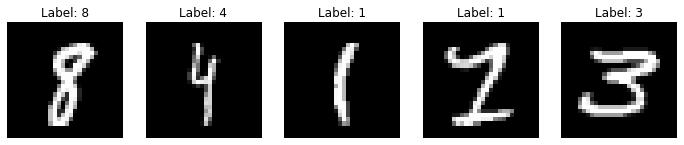

In [5]:
plot_digits(X_train, Y_train, 5)

# Neural Net Functions

In [6]:
def initialize_parameters(layers, func):
    """
    layers is a python list specifying the layer architecutre
    
    func is the activation function that will be used
    """
    
    model = []  # List of dictionaries, one dictionary for each layer
    
    # Initialize weights and biases
    for i in range(len(layers)-1):
        # Get matrix and vector sizes
        cols = layers[i]
        rows = layers[i+1]
        
        # Intialize weights and biases
        W = np.random.normal(loc=0, scale=0.01, size=(rows, cols))
        b = np.zeros((rows,1))
        
        # Save initialized weights and biases to this layer
        layer = {}
        layer["W"] = W
        layer["b"] = b
        layer["func"] = func
        
        # Save layer to model
        model.append(layer)
        
    return model

# Activation functions

In [7]:
def sigmoid(x):
    return 1 / (1+np.exp(-x))

In [8]:
def relu(x):
    return np.maximum(0,x)

# Linear forward

In [9]:
def linear_forward(layer,X):
    """
    Function that computes the linear forward for one layer
    W and X are matrices
    b is a column matrix that is added to each column in the resulting matrix
    """
    W = layer["W"]
    b = layer["b"]
    
    return np.matmul(W,X)+b

# Activation forward

In [10]:
def activation_forward(func, Z):
    """
    Function that applies the specified activation function
    to the linear output from one layer
    """
    if func == "relu":
        return relu(Z)
    
    else: # "sigmoid":
        return sigmoid(Z)

# Model forward

In [11]:
def model_forward(model,X):
    """
    Compute the output Z for the entire model given input X
    
    For each layer, plug activation output into next layer
    
    Function returns non-activated output
    """
    nr_layers = len(model)
    
    for i in range(nr_layers):
        # Get layer
        layer = model[i]
        func = layer["func"]
        
        # Save input
        layer["X"] = X
        
        # Linear forward
        Z = linear_forward(layer,X)
        layer["Z"] = Z
        
        # Activation of output
        A = activation_forward(func,Z)
        layer["A"] = A
        
        # Output becomes input
        X = A
        
    return Z

# Softmax

In [12]:
def softmax(Z):
    """
    Z is the models output represented by a (10,nr_datapoints) matrix 
    
    return Y_pred matrix where the values in ech column represent
    probabilities for that datapoint, and sum to 1
    """
    z_exp = np.exp(Z)
    Y_pred = z_exp/np.sum(z_exp,axis=0) #Specify to sum over rows
    return Y_pred

# Get prediction

In [13]:
def predict(model,X):
    """
    Given input X, calculate the models predictions with softmax
    
    returns both the linear output of the model as well as the "probabilites" from softmax
    """
    Z = model_forward(model,X)
    Y_pred = softmax(Z)
    
    return Y_pred,Z

# Cost/Loss

In [14]:
def compute_cost(Z,Y):
    """
    Takes in the model, the model prediction Z and the true labels Y
    """
    rows,cols = Z.shape
    L = np.zeros(cols)
    
    # Compute Loss
    for col in range(cols): # Iterate over all columns (datapoints)
        # Select datapoint
        Z_i = Z[:,col]
        Y_i = Y[:,col]
        
        # Stabilize by subtracting maximum
        Z_i = Z_i - np.max(Z_i)
        
        # Calculate loss according to formula
        L[col] = np.log(np.sum(np.exp(Z_i))) - np.dot(Y_i.T, Z_i)
    
    # Compute cost, mean of loss for all datapoints
    cost = np.mean(L)
    
    return cost, L

# Backward

In [15]:
def linear_backward(layer):
    """
    dW_i = dz_i x.T
    db_i = dz_i
    
    dz is a matrix, each column is a datapoint
    """
    # Read layer_state
    dz = layer["dz"]
    X = layer["X"]# input to layer
    
    # Backprop
    dW = np.dot(dz,X.T)
    db = np.mean(dz,axis=1).reshape((dz.shape[0],1)) # on average over all data points, how much where we off
    
    # Save results
    layer["dW"] = dW
    layer["db"] = db

In [16]:
def sigmoid_backward(Z):
    """
    Z is a matrix that is the input to the sigmoid
    """
    return sigmoid(Z) * (1-sigmoid(Z))

In [17]:
def relu_backward(Z):
    """
    Z is a layers linear output, matrix of size (10,:) 
    
    return a matrix with value one for positive element and 0 for negative elements
    """
    derivative_matrix = np.where(Z > 0, 1, 0)
    return derivative_matrix

In [18]:
def activation_backward(curr_layer, prev_layer):
    """
    eq. 6.27b and 6.27a
    dz_{i} = W_{i+1}^T dz_{i+1} .* act_func'(z_i)
    
    Elementwise multiplication with the derivative of the activation function
    """
    W_ii = prev_layer["W"]
    dz_ii = prev_layer["dz"]
    
    func = curr_layer["func"]
    Z = curr_layer["Z"]
    
    if func == "relu":
        curr_layer["dz"] = np.multiply(np.dot(W_ii.T,dz_ii),relu_backward(Z))
    else:
        curr_layer["dz"] = np.multiply(np.dot(W_ii.T,dz_ii),sigmoid_backward(Z))

In [19]:
def model_backward(model, Y):
    """
    Performing back propogation for the complete model, over all layers.
    
    Y is a matrix contatining the true labels
    """
    nr_layers = len(model)
    
    # Last layer
    last_layer = model[nr_layers-1]
    last_layer["dz"] = softmax(last_layer["Z"])-Y
    linear_backward(last_layer)
    
    # Remaining layers
    for i in reversed(range(1,nr_layers)):
        curr_layer = model[i-1]
        prev_layer = model[i]
        
        activation_backward(curr_layer,prev_layer)
        linear_backward(curr_layer)

    return
        

In [20]:
def update_parameters(model, learning_rate):
    """
    Update the weights and biases for each layer in the negative gradient direction.
    With step size "learning_rate"
    
    model is a list containing one dictionary per layer.
    Each dictionary store information about that layer
    """
    nr_layers = len(model)
    
    for i in range(nr_layers):
        layer = model[i]
        
        layer["W"] = layer["W"] - learning_rate*layer["dW"]
        layer["b"] = layer["b"] - learning_rate*layer["db"]
    return

# Mini batches

In [21]:
def random_mini_batches(X, Y, batch_size):
    """
    Given two matrices X and Y and a specified batch size, this function generates random
    batches where the corresponding columns (datapoints) are grouped togheter between X and Y.
    
    returns a list containing tuples of the batches.
    """
    
    mini_batches = []
    _, nr_datapoints = X.shape
    nr_batches = nr_datapoints//batch_size
    
    # Shuffle data
    shuffled_indices = np.random.permutation(nr_datapoints)
    X = X[:,shuffled_indices]
    Y = Y[:,shuffled_indices]
    
    # Organize into mini-batches
    for i in range(nr_batches):
        start = i*batch_size
        end = (i+1)*batch_size
        
        x_mini = X[:,start:end]
        y_mini = Y[:,start:end]
        mini_batches.append((x_mini, y_mini))
    
    # Remainder
    if nr_datapoints % batch_size != 0:
        start = nr_batches*batch_size
        
        x_mini = X[:,start:]
        y_mini = Y[:,start:]
        mini_batches.append((x_mini, y_mini))
    
    return mini_batches

# Accuracy

In [22]:
def get_accuracy(Y_pred, Y_test):
    """
    Y_pred and Y_test are of the shape (10,10000) 
    """
    # Initiate
    _, nr_datapoints =  Y_test.shape
    correct = 0
    
    # Iterate over data points and check if correct prediction
    for i in range(nr_datapoints):
        model_label = np.argmax(Y_pred[:,i])
        true_label = np.argmax(Y_test[:,i])
        
        if model_label == true_label:
            correct += 1
    
    # Calculate accuracy
    acc = correct/nr_datapoints
        
    return acc

# Training

In [23]:
def performance(model,X,Y):
    Y_pred,Z = predict(model, X)
    acc = get_accuracy(Y_pred, Y)
    cost,L = compute_cost(Z, Y)
    
    return cost, acc

In [24]:
def train_model(X_train, Y_train, layers, act_func, iterations, learning_rate, batch_size, X_test, Y_test):
    """
    Big training loop
    """
    # Initialize
    model = initialize_parameters(layers, act_func)
    nr_layers = len(model)
    
    # Create storge lists
    cost_list1 = []
    acc_list1 = []
    
    cost_list2 = []
    acc_list2 = []
    
    x_list = []
    
    # Print net setup
    print("Neural network architecture:")
    for i in range(nr_layers):
        layer = model[i]
        print("   Layer ",i)
        print("      dim(W)      =",layer["W"].shape)
        print("      dim(b)      =",layer["b"].shape)
        print()
    
    print("Initial performance:")
    cost,acc = performance(model,X_test,Y_test)
    print("Cost = ", cost)
    print("Acc  = ", acc)
    
    print("_____________________________________")
        
    # Train
    counter = 0
    i = 0
    for epoch in range(iterations):
        print("Epoch ",epoch+1)
        
        # Generate mini_batches for each epoch
        mini_batches = random_mini_batches(X_train, Y_train, batch_size)
        
        # Iterate over data
        for X,Y in mini_batches:

            # Forward pass in network
            model_forward(model, X)

            # Backpropogation
            model_backward(model, Y)

            # Update parameters
            update_parameters(model, learning_rate)
            
            # Plot performance
            if counter % 1000 == 0:
                # Test data
                cost,acc = performance(model,X_test,Y_test) 
                cost_list1.append(cost)
                acc_list1.append(acc)
                
                # Training data
                cost,acc = performance(model,X,Y) 
                cost_list2.append(cost)
                acc_list2.append(acc)
                
                x_list.append(counter)
            
            # Update batch_counter
            counter += batch_size
            
    print("_____________________________________")
    print("Final performance:")
    cost,acc = performance(model,X_test,Y_test)
    print("Cost = ", cost)
    print("Acc  = ", acc)
    
    return model, cost_list1, acc_list1, cost_list2, acc_list2, x_list

# Test network

In [27]:
layers = [784,128,32,10]
act_func = "relu"
iterations = 15 #nr of epochs
learning_rate = 0.001
batch_size = 100

start = time()
model, cost_list1, acc_list1, cost_list2, acc_list2, x_list = train_model(X_train, Y_train, layers, act_func, iterations, learning_rate, batch_size, X_test, Y_test)
print(f"\nTotal training time: {time()-start}")

Neural network architecture:
   Layer  0
      dim(W)      = (128, 784)
      dim(b)      = (128, 1)

   Layer  1
      dim(W)      = (32, 128)
      dim(b)      = (32, 1)

   Layer  2
      dim(W)      = (10, 32)
      dim(b)      = (10, 1)

Initial performance:
Cost =  2.3025871614460964
Acc  =  0.1159
_____________________________________
Epoch  1
Epoch  2
Epoch  3
Epoch  4
Epoch  5
Epoch  6
Epoch  7
Epoch  8
Epoch  9
Epoch  10
Epoch  11
Epoch  12
Epoch  13
Epoch  14
Epoch  15
_____________________________________
Final performance:
Cost =  0.08088834385789215
Acc  =  0.976

Total training time:153.3520152568817


# Plot performance

COST
   Test data =  0.0852084408214871
   Train data =  0.010805823993781737

ACCURACY
   Test data =  0.9734
   Train data =  1.0


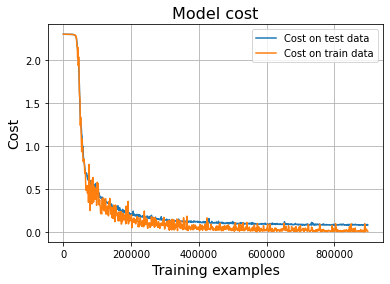

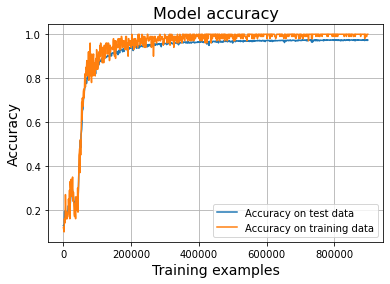

In [76]:
# Plot 1
fig1 = plt.figure()
plt.plot(x_list,cost_list1, label="Cost on test data")
plt.plot(x_list,cost_list2, label="Cost on train data")
plt.xlabel("Training examples", fontsize=14)   # increase font size
plt.ylabel("Cost", fontsize=14)   # increase font size
plt.legend()
plt.grid()
plt.title("Model cost", fontsize=16)   # increase font size
plt.savefig("cost_large_model.svg")


# Plot 2
fig2 = plt.figure()
plt.plot(x_list,acc_list1, label="Accuracy on test data")
plt.plot(x_list,acc_list2, label="Accuracy on training data")
plt.xlabel("Training examples", fontsize=14)   # increase font size
plt.ylabel("Accuracy", fontsize=14)   # increase font size
plt.grid()
plt.legend()
plt.title("Model accuracy", fontsize=16)   # increase font size
plt.savefig("accuracy_large_model.svg")




print("COST")
print("   Test data = ",cost_list1[-1])
print("   Train data = ",cost_list2[-1])
print("\nACCURACY")
print("   Test data = ",acc_list1[-1])
print("   Train data = ",acc_list2[-1])

# Plot weight matrices

In [77]:
def print_weights(model):
    """
    Print rows of weight matrices
    """
    
    nr_layers = len(model)
    
    for i in range(nr_layers):
        
        print("Layer",i)
        layer = model[i]
        W = layer["W"]
        rows,cols = W.shape
        
        plt.figure(i)
        for row in range(rows):
            im = W[row,:].reshape((28,28))
            
            plt.subplot(2, 5, row+1)
            plt.imshow(im, cmap='gray')
            plt.title(str(row))
            plt.gca().set_xticks([])
            plt.gca().set_yticks([])
        plt.savefig("weights.eps")

# Validate results

In [78]:
def find_mistakes(Y_pred, Y_test):
    """
    Y_pred is a matrix of size (10,10000). 10 are the labels and 10000 are the datapoints
    Y_test is a matrix of size (10,10000). 10 are the labels and 10000 are the datapoints
    """
    
    pred_labels = np.argmax(Y_pred, axis=0)
    true_labels = np.argmax(Y_test,axis=0)
    
    indices = np.array(np.where(pred_labels != true_labels)).reshape(-1)
    
    return indices

### Print mistakes

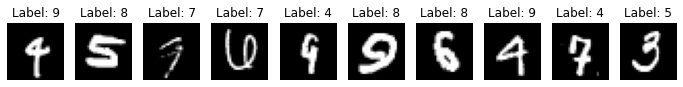

In [79]:
Y_pred,_ = predict(model,X_test)
indices = find_mistakes(Y_pred, Y_test)

Z,_ = predict(model,X_test[:,indices])
plot_digits(X_test[:,indices], Z, 10)


### Print random

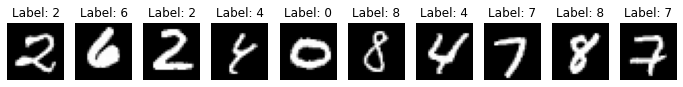

In [80]:
Z,_ = predict(model,X_test)
plot_digits(X_test, Z, 10)